In [20]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
from IPython.display import display

In [2]:
plt.style.use("seaborn-pastel")
plt.rcParams['figure.figsize'] = (10, 7)

In [3]:
df = pd.read_csv('data/streaming_history.csv', parse_dates=['endTime'])
tracks_df = pd.read_csv('data/tracks.csv', parse_dates=['album_release_date'])
features_df = pd.read_csv('data/features.csv')

In [4]:
df.dropna(inplace=True)

In [5]:
df = df.merge(tracks_df, left_on='id_', right_on='id_', suffixes=('stream_', 'track_'))\
       .merge(features_df, left_on='id_', right_on='id_', suffixes=('stream_', 'feature_'))

Listening mostly during the workong hours.

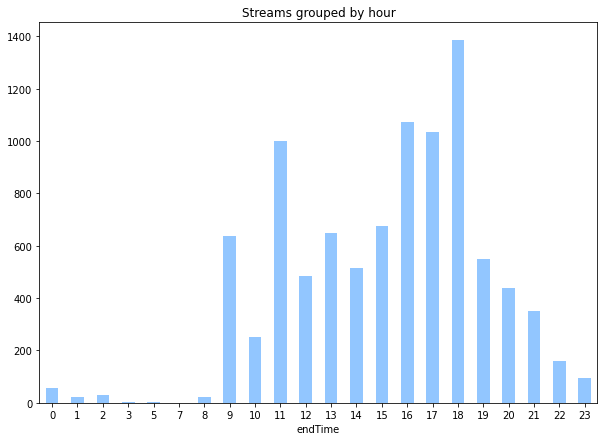

In [6]:
df.groupby(df.endTime.dt.hour)["endTime"].count().plot(kind='bar', rot=0, title='Streams grouped by hour');

In [7]:
@np.vectorize
def sort_key_day_of_week_names(name):
    return pd._libs.tslibs.fields.DAYS_FULL.index(name)


@np.vectorize
def sort_key_month_names(name):
    return pd._libs.tslibs.fields.MONTHS_FULL.index(name)

And during working days of week.

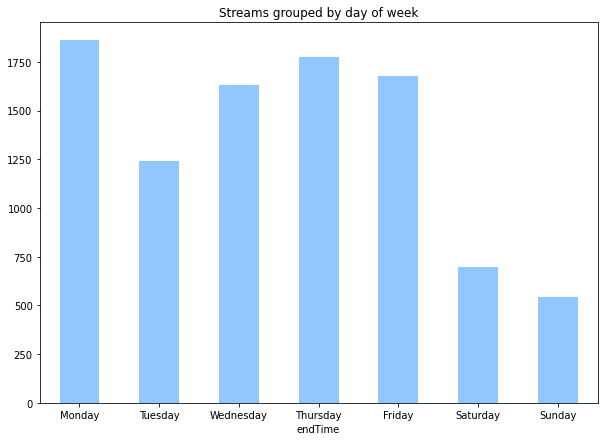

In [8]:
df.groupby(df.endTime.dt.day_name(locale='en_GB.UTF-8'))["endTime"].count()\
.sort_index(key=sort_key_day_of_week_names)\
.plot(kind='bar', rot=0, title='Streams grouped by day of week');

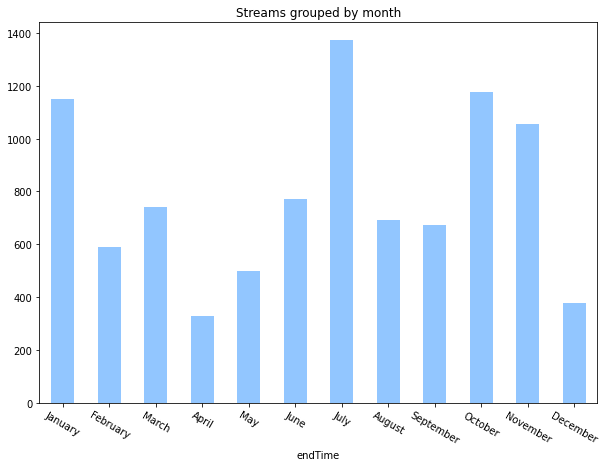

In [9]:
df.groupby(df.endTime.dt.month_name(locale='en_GB.UTF-8'))["endTime"].count()\
.sort_index(key=sort_key_month_names)\
.plot(kind='bar', rot=-30, title='Streams grouped by month');

,Number of stremed tracks per day
count,367.000000
mean,25.697548
std,45.957019
min,0.000000
25%,0.000000
50%,1.000000
75%,33.000000
max,309.000000


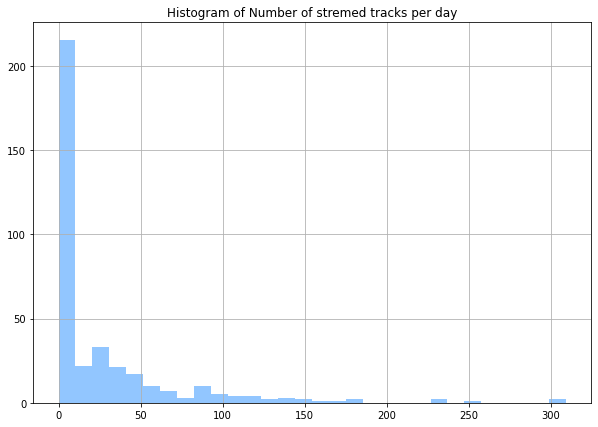

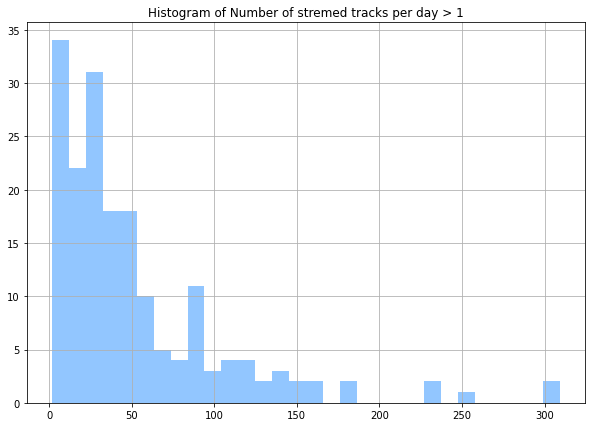

In [10]:
n_date_ts = df.groupby(df['endTime'].dt.date)['endTime'].count()
n_date_ts.index = pd.DatetimeIndex(n_date_ts.index)
n_date_ts = n_date_ts.resample('D').sum().fillna(0)
n_date_ts.name = "Number of stremed tracks per day"
display(n_date_ts.to_frame().describe())
n_date_ts.hist(bins=30); plt.title(f"Histogram of {n_date_ts.name}"); plt.show()
n_date_ts[n_date_ts > 1].hist(bins=30); plt.title(f"Histogram of {n_date_ts.name} > 1"); plt.show()

In [33]:
def rare_ticks(ax, step):
    labels = ax.xaxis.get_ticklabels()[::step]
    ax.set_xticks(ax.get_xticks()[::step])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels([l.get_text().split(' ')[0] for l in labels])
    plt.gcf().autofmt_xdate()

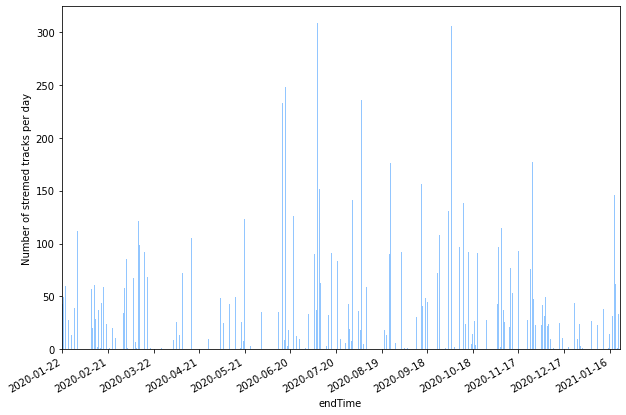

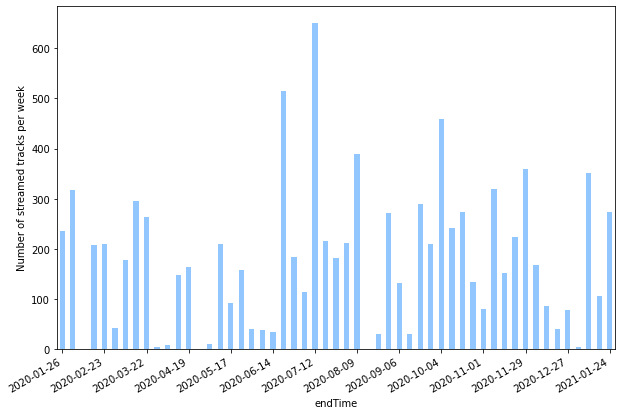

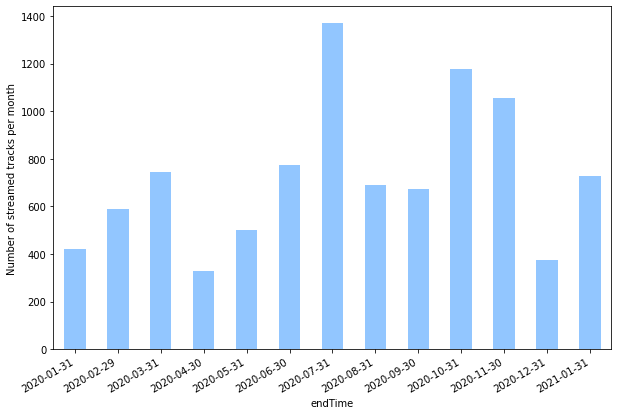

In [37]:
ax = n_date_ts.resample('D').sum().fillna(0).plot(kind='bar', ylabel=n_date_ts.name)
rare_ticks(ax, 30)
plt.show()

ax = n_date_ts.resample('W').sum().fillna(0).plot(
    kind='bar', ylabel='Number of streamed tracks per week'
)
rare_ticks(ax, 4)
plt.show()

ax = n_date_ts.resample('M').sum().fillna(0).plot(
    kind='bar', ylabel='Number of streamed tracks per month'
)
rare_ticks(ax, 1)
plt.show()

In [14]:
report = df.profile_report()
with open('initial_report.html', 'w') as f:
    f.write(report.to_html())

Summarize dataset:   0%|          | 0/46 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Profiling conclusions

#### 1. Drop `album_type`, `artist1_type`, `artist2_type`, `is_local`, `type`

In [16]:
drop_cols =  ['album_type', 'artist1_type', 'artist2_type', 'is_local', 'type']
df.drop(columns=drop_cols, inplace=True)

#### 2. Review cases where `id_` is the same but `artist+track` differs

In [17]:
# 2. Review cases where id_ is the same but artist+track differs
dup_track_names_df = df.groupby('id_')['artist+track']\
                       .apply(lambda x: x.nunique()).to_frame()\
                       .query('`artist+track` > 1')\
                       .merge(df[['id_', 'artist+track']].drop_duplicates(),
                              on='id_', how='left')

dup_track_names_map = dup_track_names_df.drop_duplicates('id_').set_index('id_')['artist+track_y']
indexer = df['id_'].isin(dup_track_names_map.index)
df.loc[indexer, 'artist+track'] = dup_track_names_map.loc[df[indexer]['id_'].values].values

with pd.option_context('display.max_rows', None):
    display(dup_track_names_df.iloc[:10])
    
assert df.groupby('id_')['artist+track']\
         .apply(lambda x: x.nunique()).to_frame()\
         .query('`artist+track` > 1').shape[0] == 0

,id_,artist+track_x,artist+track_y
0,05uDoA9W1y2zz7A1Rh55tN,2,Dir En Grey Vinushka
1,05uDoA9W1y2zz7A1Rh55tN,2,Dir En Grey VINUSHKA
2,0jOnZhF75V68VsBObWx2XO,2,Camille Saint-Saëns The Carnival of the Animal...
3,0jOnZhF75V68VsBObWx2XO,2,Camille Saint-Saëns The Carnival of the Animal...
4,0yzhOPf0iw2qWwcXRRta5L,2,George Gershwin Rhapsody In Blue
5,0yzhOPf0iw2qWwcXRRta5L,2,George Gershwin Rhapsody in Blue
6,1KWnQm0vBfn1Xhc5CM8swv,2,Forest Swords Crow - DJ-Kicks
7,1KWnQm0vBfn1Xhc5CM8swv,2,Forest Swords Crow (DJ-Kicks) - Mixed
8,1X8iYVZACg3lYmnfd6A6fk,2,IAMX Mile Deep Hollow
9,1X8iYVZACg3lYmnfd6A6fk,2,IAMX Mile Deep Hollow - Single Rework


Just slightly different spelling, so it was decided for each track to use the first occurd version.

#### 4. Dropping streams with less than 60 seconds pleayed

In [18]:
# 4. Possibly drop streams with 60 seconds pleayed
threshold = 60 * 1000
ms_filter = df.msPlayed > threshold 
print(f'Records with less than {threshold} ms: {(~ms_filter).sum()}')

Records with less than 60000 ms: 4926


#### 5. From `album_release_date` tracks from 10s and 00s are streamed more, but it could be related to sptify recommendation system which (feels like) suggests more recent tracks. How it would look like if < 60 seconds streams was deleted?

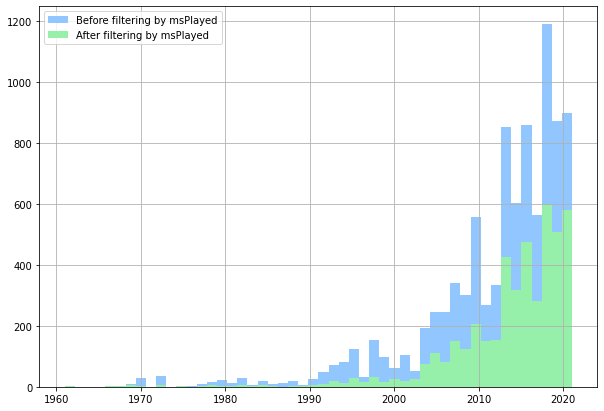

In [19]:
# 5. From album_release_date tracks from 10s and 00s are streamed more, 
# but it could be related to sptify recommendation system which (feels like) 
# suggests more recent tracks. How it would look like if < 60 seconds streams was deleted?
df.album_release_date.rename('Before filtering by msPlayed').hist(bins=50, legend=True)
df[ms_filter].album_release_date.rename('After filtering by msPlayed').hist(bins=50, legend=True);

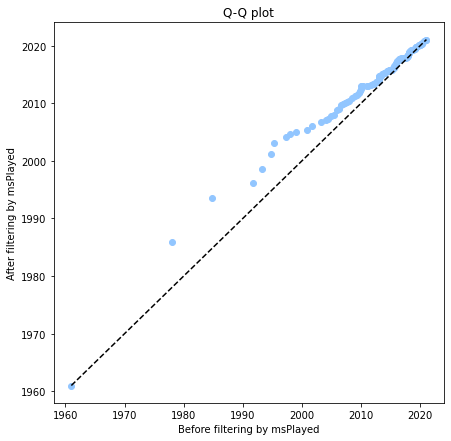

In [20]:
percs = np.linspace(0,1,101)
qn_a = df.album_release_date.quantile(percs)
qn_b = df[ms_filter].album_release_date.quantile(percs)

plt.figure(figsize=(7, 7))
plt.plot(qn_a,qn_b, ls="", marker="o")
plt.title('Q-Q plot')
plt.xlabel('Before filtering by msPlayed')
plt.ylabel('After filtering by msPlayed')

start = np.min((qn_a.min(),qn_b.min()))
end = np.max((qn_a.max(),qn_b.max()))
plt.plot([start, end], [start, end], color="k", ls="--")

plt.show()

From Q-Q plot, looks like after filtration more recent songs have larger share, mostly by removing songs from 80s and 90s.

#### 6.`popularity`

In [21]:
def tops_by(df_, col, n=10):
    display(f'Top {n} by {col}')
    display(df_[ms_filter].groupby('id_')[['artist+track', col]].min()\
            .sort_values(col, ascending=False).iloc[:n])

    display(f'Bottom {n} by {col}')
    display(df_[ms_filter].groupby('id_')[['artist+track', col]].min()\
            .sort_values(col).iloc[:n])

In [22]:
groups_artist_track = df[ms_filter].groupby('id_')

<AxesSubplot:>

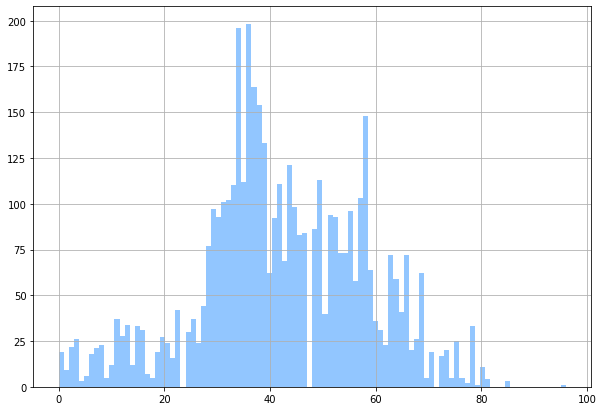

In [24]:
df[ms_filter]['popularity'].hist(bins=100)

Mostly 30-70 popularity tracks.

In [38]:
popularity = groups_artist_track[['artist+track', 'popularity']].min()\
             .reset_index(drop=True).set_index('artist+track')['popularity']

In [39]:
popularity[popularity.between(30, 70)].sample(10)

artist+track
Skinshape Old Days                             39
The Raconteurs Level                           52
DakhaBrakha Vesna                              42
MEUTE Slip                                     43
Oasis Don't Look Back in Anger - Remastered    70
Radiohead 15 Step                              60
Muse Butterflies and Hurricanes                56
Vast Touched                                   39
Orbital Tiny Foldable Cities - Edit            41
Röyksopp Rong                                  34
Name: popularity, dtype: int64

In [40]:
(popularity < 30).sum() / popularity.shape[0]

0.23090799759470837

There's 23% of less popular songs. Mostly includes classical music, some more of my personal picks in other ganres plus the spotify recommendations of the lesser known artists, which tells me that spotify does a good job (at least in my case) of giving more exposure for new or smaller artists.

In [43]:
popularity[popularity < 30].sample(10)

artist+track
Dmitri Shostakovich Symphony No. 10 in E Minor, Op. 93: I. Moderato                                18
Claude Debussy Children's Corner, L. 113: VI. Golliwogg's Cake-Walk                                13
Spector Bad Boyfriend                                                                              22
P.T. Adamczyk Lair Of The Beast                                                                    25
Antonio Vivaldi L'incoronazione di Dario, RV 719: Mi va scherzando in sen                           7
Andre Caplet Suite bergamasque, L. 75 (Arr. for Orchestra): I. Prelude                              8
La Femme Interlude                                                                                 29
Ennio Morricone Neve - From "The Hateful Eight" Soundtrack / Versione Integrale                    22
Dmitri Shostakovich Symphony No. 7 in C Major, Op. 60 "Leningrad": I. Allegretto (Live)            18
Pyotr Ilyich Tchaikovsky Symphony No. 5 in E Minor, Op. 64, TH 29: II

Only 3% present of the tracks are more popular than 70.

In [47]:
(popularity > 70).sum() / popularity.shape[0]

0.03607937462417318

In [48]:
print('the most popular ones from my streaming history')
popularity.sort_values(ascending=False).iloc[:10]

the most popular ones from my streaming history


artist+track
The Weeknd Blinding Lights                                 96
Doja Cat Say So                                            85
Arctic Monkeys Why'd You Only Call Me When You're High?    85
The White Stripes Seven Nation Army                        81
Grouplove Tongue Tied                                      81
The Killers Mr. Brightside                                 80
Radiohead Creep                                            80
Eurythmics Sweet Dreams (Are Made of This) - Remastered    80
MGMT Little Dark Age                                       80
Gorillaz Feel Good Inc.                                    80
Name: popularity, dtype: int64

#### 7.  `danceability`

Description from spotify:  
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

<AxesSubplot:>

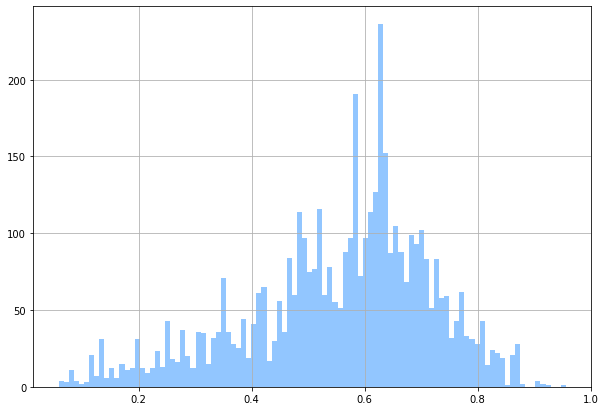

In [52]:
df[ms_filter]['danceability'].hist(bins=100)

In [50]:
tops_by(df, 'danceability', 20)

'Top 20 by danceability'

,artist+track,danceability
id_,,
1pKYYY0dkg23sQQXi0Q5zN,Daft Punk Around the World,0.956
2y6GwZJLXU1A2eRG09pbMv,Róisín Murphy Narcissus - Extended Mix,0.923
2PfPIIxUiH9Y7miXqiQdqv,L'Impératrice Peur des filles,0.915
2cQflnqpYkXUhKh7IwExwn,TT The Artist Off the Chain,0.907
1HI2DCMcSu1DaRm1cu3RNK,Róisín Murphy Dear Miami,0.907
2QodXkDpgpyTzSJ7oftvjq,Monetochka Русский ковчег,0.877
7FRP87A2Bft7zMhFlI7j1n,Róisín Murphy Murphy's Law - Edit,0.875
6oDeZwfb2Odvvlp4a7lnxB,Melkeveien Peter Pan Death Wish,0.872
4IekHBYUwUNLILgA9R22OD,Gorillaz Revolving Doors,0.872


'Bottom 20 by danceability'

,artist+track,danceability
id_,,
1frGIyTaTjvksS8FhyoqYx,"Marcin Przybyłowicz Eredin, King Of The Hunt",0.0581
2fMn5KBVhGlBQZTGrSBeZ7,"Dmitri Shostakovich The Gadfly Suite, Op. 97a:...",0.0636
2Oq7phiwlXV5VfMEreF6CH,"Claude Debussy String Quartet in G Minor, Op. ...",0.0646
7Br8VQqZs2KJESjzCTfezZ,"Jean Sibelius Valse triste, Op. 44",0.0740
04ynRoYdUQtiJogTIavITM,Kyle Preston Refraction,0.0751
7nl1J2I4DJcnboWaKopWrc,"Camille Saint-Saëns Symphony No. 2 in A Minor,...",0.0773
0cqcRqZgkNHanWQ8slYA0v,Gustav Mahler Mahler: Symphony No. 5 in C-Shar...,0.0783
3Vdo06F62qbnxoARewCmAe,Mondkopf Afternoon,0.0800
2kAgCRZPG3YQR2VMqRvLmb,Ralph Vaughan Williams The Lark Ascending,0.0811


Here I see a bit strange results. Top is populated by electronic tracks but not all of them are that 'danceable'. For example, `Tricky Lonely Dancer` contains `dancer` in the name but I'd say it could be for more 'meditative' types of dances.

#### 8. `loudness`

Description from Spotify:  
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

In [51]:
tops_by(df, 'loudness', 10)

'Top 10 by loudness'

,artist+track,loudness
id_,,
10qbHF920zH5K8C8IcE5AL,Carpenter Brut Turbo Killer,-1.673
21Qsj3cMVCx2xF2EVVNbEu,The White Stripes Fell In Love With A Girl,-1.742
18A7ha5BitZjmdHTCwXFbU,Sub Urban Cradles,-1.870
4Ruu7Rn16q2HAie75Y6N9f,OOMPH! Sex hat keine Macht - Single Edit,-1.880
0HKr9aqzHBsVNnsUCdH4bw,Rina Sawayama STFU!,-1.880
1gCYG3j4dpZLIE7u6uz2aB,Oasis The Importance of Being Idle,-2.111
0OBeiL3ie4hWIKCPGzwhQh,Franz Ferdinand This Boy,-2.138
0LtOwyZoSNZKJWHqjzADpW,Tame Impala Feels Like We Only Go Backwards,-2.352
10Nmj3JCNoMeBQ87uw5j8k,Red Hot Chili Peppers Dani California,-2.360


'Bottom 10 by loudness'

,artist+track,loudness
id_,,
3dM17QmRwOJZsjGYr8PVTo,Dmitri Shostakovich String Quartet No. 7 in F-...,-40.385
46TzngK2DGxxn3yO3gjTGe,Dmitri Shostakovich Piano Concerto No. 2 Op. 1...,-38.863
1qbrS9PKOzsack0g7LiBhh,John Cage In A Landscape,-37.422
7nl1J2I4DJcnboWaKopWrc,"Camille Saint-Saëns Symphony No. 2 in A Minor,...",-37.260
2JRehMMtFkGj0Agux7LNWs,Dmitri Shostakovich Piano Concerto No. 2 in F ...,-36.382
4BlM6AO7TOtqxcY9qMHIuc,George Gershwin Song Book: The Man I Love. Slo...,-36.027
7soiuxMmcrTDS51IVBMXlc,"Pyotr Ilyich Tchaikovsky Swan Lake (Suite), Op...",-35.610
4vi9pBR7yJhBzGaNu0k1gj,"Robert Schumann Kinderszenen, Op. 15: No. 1, V...",-35.546
64gNY91aF5i2tOdjHn60hL,"Camille Saint-Saëns Le carnaval des animaux, R...",-35.392


#### 9. `speechiness`

Description from Spotify:
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

In [54]:
speechiness = groups_artist_track[['artist+track', 'speechiness']].min()\
             .reset_index(drop=True).set_index('artist+track')['speechiness']

Very "speechy" tracks are all from The Hateful Eight soundrack album. There could be some podcasts, but Spotify is blocking podcasts for Belarus.

In [55]:
speechiness[speechiness > 0.66]

artist+track
Samuel L. Jackson "Son Of The Bloody Nigger Killer Of Baton Rouge" - From "The Hateful Eight" Soundtrack    0.907
Samuel L. Jackson "Uncle Charlie's Stew" - From "The Hateful Eight" Soundtrack                              0.880
Tim Roth "Frontier Justice" - From "The Hateful Eight" Soundtrack                                           0.804
Name: speechiness, dtype: float64

Strange to see `The Greenwich Trio Shostakovich: Piano Trio No.2, Op. 67- 4. Allegretto` in the 0.33-0.66 speachiness range. This piece is without the vocals, but for the spotify's algorithm, it might seem that there are very intonationally 'talkative' instruments in this one.

In [57]:
speechiness[speechiness.between(0.33, 0.66)]

artist+track
Ibeyi River                                                                         0.474
Led Zeppelin Whole Lotta Love - 1990 Remaster                                       0.405
Sub Urban Cradles                                                                   0.369
RefraQ RUK                                                                          0.377
The Greenwich Trio Shostakovich: Piano Trio No.2, Op. 67- 4. Allegretto             0.448
TT The Artist Off the Chain                                                         0.366
Kurt Russell "This Here Is Daisy Domergue" - From "The Hateful Eight" Soundtrack    0.541
Orelsan Notes pour trop tard (feat. Ibeyi)                                          0.447
Mr. Oizo Pharmacist                                                                 0.392
Sub Urban Freak (feat. REI AMI)                                                     0.515
Stromae Bienvenue Chez Moi                                                          0.3

#### 10. `acousticness`

From Spotify:  
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

<AxesSubplot:>

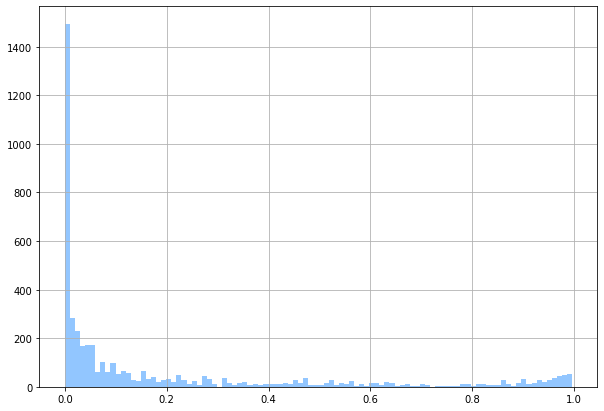

In [60]:
df[ms_filter]['acousticness'].hist(bins=100)

In [61]:
tops_by(df, 'acousticness',  10)

'Top 10 by acousticness'

,artist+track,acousticness
id_,,
5fdp9rXfEixCGLM1Og4EN1,Erik Satie Gnossienne No. 1,0.996
4vi9pBR7yJhBzGaNu0k1gj,"Robert Schumann Kinderszenen, Op. 15: No. 1, V...",0.996
4BlM6AO7TOtqxcY9qMHIuc,George Gershwin Song Book: The Man I Love. Slo...,0.996
0bi8WWgQFY9TQE8W0IrWv8,"Frédéric Chopin Mazurka No. 19 in B Minor, Op....",0.995
1MdyM9kjlkC0JMXUpbyq1f,"Frédéric Chopin 12 Etudes, Op.10: No. 3. In E ...",0.995
4F2puWg6sWxK3EvSFF4w9q,"Frédéric Chopin Mazurka No. 49 in A Minor, Op....",0.995
4DM2zsfT8vIHPiVpUyzNnv,"Claude Debussy Préludes / Book 1, L.117: 1. Da...",0.995
46tPGzCXCI2oKsemztDA9u,Jan Garbarek Parce Mihi Domine,0.995
2uHTrJbmRPjGVcLxdFlEtT,"Frédéric Chopin Nocturne No. 9 in B Major, Op....",0.995


'Bottom 10 by acousticness'

,artist+track,acousticness
id_,,
3qCd3yulIqk2U4D0vzIqpF,93MillionMilesFromTheSun All Am Now,0.000002
1XmJmoaPWiqo6a3V73prjq,The Whip Trash - Original,0.000003
6TnVq5IX8ODlc58uWo5Sgk,Dir En Grey Different Sense,0.000003
203c3jfQ4JZn1BBfXG84I4,The Bravery An Honest Mistake,0.000003
37fK2T1451kgjvgzumrjNZ,Dir En Grey The Final,0.000003
6hhbgVf8NMXofn6F2Y4bXu,The Soft Moon Choke,0.000003
7iQmD0bfguAQOpU1V3Bp8w,Noel Gallagher's High Flying Birds Holy Mountain,0.000005
1YcB54f8B0bHzwjzNpcPBi,SONOIO Enough,0.000007
7wrxqCe8rFwB2niUX1SWMD,A Place To Bury Strangers Everything Always Go...,0.000007


#### 11. `instrumentalness`

From Spotify:  
Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

<AxesSubplot:>

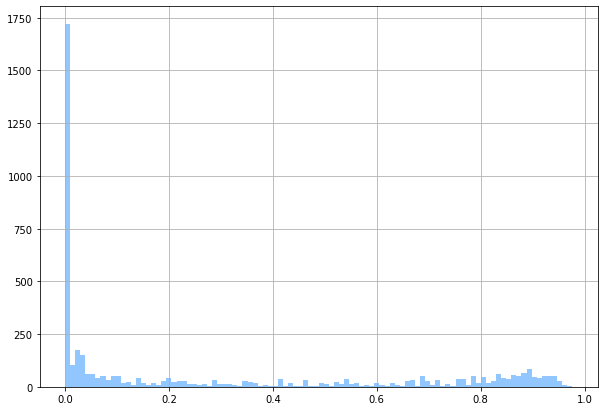

In [62]:
df[ms_filter]['instrumentalness'].hist(bins=100)

In [63]:
tops_by(df, 'instrumentalness', 10)

'Top 10 by instrumentalness'

,artist+track,instrumentalness
id_,,
5fOB2AbSr4bA35Y7wletOT,Gary Numan Trois Gymnopedies (First Movement),0.976
7JHcYbRa9OSmZomT8v65Ec,TR/ST cor,0.973
5ugeaq1zuZx7xPq1q8Xlf8,Anastasia Chimes of Tibet,0.972
2ZNxK9swHaIycklmPj2vRb,Sleep Party People Silent Night,0.970
5fr0ocIee7TpDCRWaK0002,Pastel Ghost Clouds,0.964
2hinqo5HVB7qla5iMrKUFB,Clark Winter Linn,0.962
2YxoC2dYOotjqt08dEifsc,Boards of Canada Chromakey Dreamcoat,0.961
1u1ATklwZesAvq1whHsI8Z,Vangelis Blade Runner - End Titles,0.960
5tmhUzJuP7XwqCHglyqnt8,Marcin Przybyłowicz Geralt Of Rivia,0.957


'Bottom 10 by instrumentalness'

,artist+track,instrumentalness
id_,,
003vvx7Niy0yvhvHt4a68B,The Killers Mr. Brightside,0.0
35PWRfGLLRHJ5sJ5KbC6Y4,FFS Police Encounters,0.0
0PHTufT46ytsqcH8OsQHvp,Bat For Lashes Laura,0.0
3SgnYOV9ONL0bIHaAcOYE1,Orelsan Notes pour trop tard (feat. Ibeyi),0.0
3ZOEytgrvLwQaqXreDs2Jx,Red Hot Chili Peppers Can't Stop,0.0
3ggHg86KSSKbqdMUjmsVqk,Iosonouncane Il corpo del reato,0.0
3jrw6NCITSvDZUgiqTEjdh,The Cribs I'm a Realist,0.0
3pqRRxH5x9oVPwh9i9UFZA,Franz Ferdinand Tell Her Tonight,0.0
3qWNgvQTzSbA67Z4r0mX9O,Orelsan Paradis,0.0


#### 12. `liveness`

From Spotify:  
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

<AxesSubplot:>

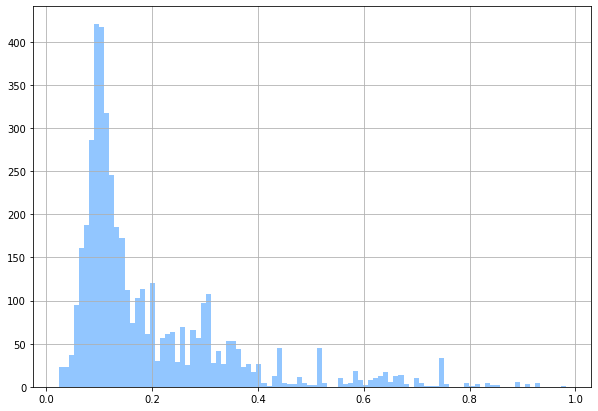

In [64]:
df[ms_filter]['liveness'].hist(bins=100)

In [65]:
tops_by(df, 'liveness', 10)

'Top 10 by liveness'

,artist+track,liveness
id_,,
4P3kr3B9V0gQits3ltOMmr,Pulp Death II,0.982
24s8ZH2RcYLs2ODag8MzUl,The Dø Miracles (Back in Time),0.934
7wrxqCe8rFwB2niUX1SWMD,A Place To Bury Strangers Everything Always Go...,0.908
54PfFfe1TqscAv5FQ49xsk,Basement Jaxx Take Me Back To Your House,0.892
21Qsj3cMVCx2xF2EVVNbEu,The White Stripes Fell In Love With A Girl,0.853
4Ruu7Rn16q2HAie75Y6N9f,OOMPH! Sex hat keine Macht - Single Edit,0.845
2DgFCys3XMrWZDngu1CrRy,The Avalanches Since I Left You,0.840
6shny2UVkpaLc7jEKEoePa,Bring Me The Horizon ¿ (feat. Halsey),0.838
2wEHxTBxLJk3vYzyW6dsAU,Portishead Glory Box - Live,0.838


'Bottom 10 by liveness'

,artist+track,liveness
id_,,
3OQGpcCuGCIJXGHy0NEVPS,Yelle Karaté,0.0230
1Hv1VTm8zeOeybub15mA2R,Sade Smooth Operator - Single Version,0.0298
08KTQSs3ickNki7FFTb6fY,The Orion Experience The Cult of Dionysus,0.0320
1chllgUtwX48FHVPliOYyF,Ghostpoet Freakshow,0.0322
0Ja4hLKiUSw01E01pJ1yGr,The Prodigy Breathe,0.0370
2YkAdUmoSynijPSij1uNIN,Hatari Hlauptu,0.0370
4znkNgqRMCF12mY7EbklsA,Duran Duran Notorious,0.0372
4QtScYyh6Yxio27udYPhh0,"DNA Tom's Diner - 7"" Version",0.0403
76SEZdYnMNnUqi43anI14r,Rainbow Gates Of Babylon,0.0412


Well, only 1 track from top 10 is an actual live recording, so 'liveness' is not a very good indicator or there were confusions during the scapping since originally IDs for the tracks were obtained through `search` endpoint.

#### 13. `valence`

From Spotify:  
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

<AxesSubplot:>

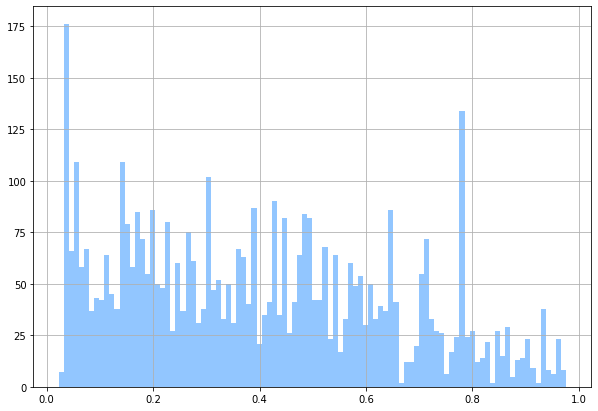

In [66]:
df[ms_filter]['valence'].hist(bins=100)

In [68]:
tops_by(df, 'valence', 10)

'Top 10 by valence'

,artist+track,valence
id_,,
2ljkrYRtQW3pAEwDbVQb9S,How To Destroy Angels Fur Lined,0.976
6Fi55WOjX9DvCo5Jsc2pZ4,Arnaud Rebotini Chloroquine,0.972
4fPBB44eDH71YohayI4eKV,The Strokes You Only Live Once,0.968
4Hff1IjRbLGeLgFgxvHflk,Gorillaz DARE,0.966
3Vby4nGmtbDo7HDJamOWkT,Stealers Wheel Stuck In The Middle With You,0.964
5QLHGv0DfpeXLNFo7SFEy1,The Smashing Pumpkins 1979 - Remastered 2012,0.964
7oCvmLvQnAh8GIMY6wFgv0,LA Priest What Moves,0.964
6xbDAaVUnQ2kaPAg5GXjFW,Gorillaz Detroit,0.963
3BMqVk2NJbH4fxf84e8kDC,Marie Madeleine Swimming Pool,0.963


'Bottom 10 by valence'

,artist+track,valence
id_,,
3FROPxW9p21UQO7vIkWx4o,"Ennio Morricone Neve - From ""The Hateful Eight...",0.0225
3Vdo06F62qbnxoARewCmAe,Mondkopf Afternoon,0.0252
6fGFETkJMbFiPRHKhkUdMY,"Ennio Morricone Neve - From ""The Hateful Eight...",0.0305
2Vlm1bUvqI6NIUyLQ1shII,"Claude Debussy Nocturnes, L. 91: Sirenes",0.0307
1UBveijBRq8yxDwGNgXbnK,"Ennio Morricone Overture - From ""The Hateful E...",0.0313
4qaMBzyeNcpvvGdxVguylk,Marcin Przybyłowicz Wind In The Caroberta Woods,0.0316
7I0FxWhgPySvQ0CVs99SKx,"Jean Sibelius The Swan Of Tuonela, Op.22, No.2...",0.0322
4UXmLp8w047yBpivn2Ijo7,Chapelier Fou Artifices,0.0323
0cqcRqZgkNHanWQ8slYA0v,Gustav Mahler Mahler: Symphony No. 5 in C-Shar...,0.0327


Mostly love songs in the top and songs with not many different words. But surprised to see `The Smashing Pumpkins 1979`, always perceieved it as melancholic, just take these lyrics:
```
And I don't even care to shake these zipper blues
And we don't know just where our bones will rest
To dust I guess forgotten and absorbed
Into the earth below
```
not very cheerful, are they?

In [ ]:
# 14. Almost uniform valence (up to 0.6). Interpretation?
df[ms_filter].groupby('id_')[['artist+track', 'valence']].min().sort_values('valence', ascending=False)

#### `tempo`

From Spotify:  
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

<AxesSubplot:>

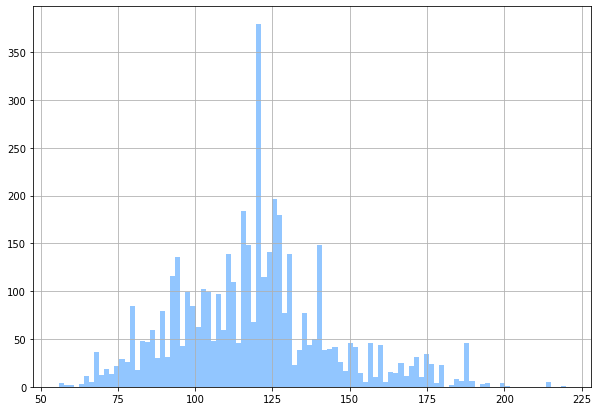

In [69]:
df[ms_filter]['tempo'].hist(bins=100)

In [70]:
tops_by(df, 'tempo', 10)

'Top 10 by tempo'

,artist+track,tempo
id_,,
3qCd3yulIqk2U4D0vzIqpF,93MillionMilesFromTheSun All Am Now,219.905
74quLhuRBoSU6zMagxUQZC,The xx Shelter,214.670
1t18idTmPA3sWLxYUWwesw,Franz Ferdinand Paper Cages,200.365
5l4eNAXmYK9uLx5P2RMPq9,Corpo-Mente Scylla,200.131
57HNTVH3qpDVOGEzFB1dda,Grimes Violence - Club Mix,199.929
5rDdhgSxkryYbWyjYjMx85,UNKLE Burn My Shadow,193.966
1660mEFehJyuRbt9m2E3R1,Misun After Me,193.930
2bfGNzdiRa1jXZRdfssSzR,Gorillaz Dirty Harry,192.296
01wsKcJ8ptqUmatpJlEGYj,Arcade Fire Ready to Start,190.080


'Bottom 10 by tempo'

,artist+track,tempo
id_,,
7pM9cLbrgRGX1hHElTX92m,Lorn Acid Rain,55.803
1frGIyTaTjvksS8FhyoqYx,"Marcin Przybyłowicz Eredin, King Of The Hunt",58.144
6tQCCjZUZQnGi2m2M3c6TV,Hatari Ógleði,59.985
5aVGbJhLv5b2Dii8wKvj0K,"Dmitri Shostakovich The Gadfly Suite, Op. 97a:...",60.017
5LPFxlca8oNgp8ywfOjT3f,London Grammar If You Wait,63.954
4H4c8Z80iraxa7CBBpGlTf,"Claude Debussy Préludes, Book 1, L. 117: No. 3...",64.330
5ugeaq1zuZx7xPq1q8Xlf8,Anastasia Chimes of Tibet,64.497
51i0mqROX4e3PWiJ8t5v82,"Johann Sebastian Bach Goldberg Variations, BWV...",64.680
6ANtVmKtTBDrUKi7ch96Vm,Wolfgang Amadeus Mozart Concerto No. 21 in C M...,64.871
